In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Hay varios modelos que se pueden utilizar para estimar el flujo vehicular para las próximas semanas en cada autopista. Algunos ejemplos incluyen:

- Modelos basados en séries de tiempo: Estos modelos utilizan la información temporal para estimar el flujo vehicular en el futuro. Por ejemplo, se puede utilizar un modelo ARIMA (Auto Regressive Integrated Moving Average) o un modelo SARIMA (Seasonal ARIMA) para modelar la cantidad de vehículos en cada autopista en función del tiempo.

- Modelos basados en regresión: Estos modelos utilizan la información de las variables explicativas para estimar la cantidad de vehículos. Por ejemplo, se puede utilizar una regresión lineal o una regresión no lineal para estimar la cantidad de vehículos en función de la hora del día, el día de la semana, la ubicación de la autopista, entre otros.

La elección del modelo dependerá de los datos disponibles y de las características de la serie de tiempo. Por ejemplo, si la serie de tiempo tiene una tendencia clara y una estacionalidad, es posible que un modelo SARIMA sea el mejor ajuste. Si hay variables explicativas disponibles que puedan tener un impacto en la cantidad de vehículos, un modelo basado en regresión puede ser más adecuado.

Para evaluar la performance del modelo, se pueden utilizar medidas como el Mean Absolute Error (MAE), el Mean Squared Error (MSE), y el Root Mean Squared Error (RMSE). Estas medidas miden la diferencia entre los valores pronosticados y los valores reales y permiten comparar diferentes modelos y elegir el que tenga un menor error. También se pueden utilizar medidas de validación cruzada como el k-fold cross validation para estimar la precisión del modelo en datos no vistos.

Por temas de tiempo se realizara un modelo de regresion con xgboost, ya que realizar un modelo en series de tiempo se necesita aun mas analsisi de informacion y son mucho mas robustos para la inplementacion del mismo, volviendolo algo sensible a otras caracteristicas. 

In [55]:
# Importar las bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import test_talent.utils.paths as path
from test_talent.utils.talent_utils import update_model, save_simple_metrics_report, get_model_performance_test_set

In [66]:
# Cargar el dataset
df = pd.read_csv(path.data_processed_dir('data_clean.csv'))
df.isna().sum()

Fecha          0
Hora           0
Auto_Nombre    0
Cant_Veh       0
dia            0
mes            0
anio           0
dtype: int64

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26394 entries, 0 to 26393
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Fecha        26394 non-null  object 
 1   Hora         26394 non-null  int64  
 2   Auto_Nombre  26394 non-null  object 
 3   Cant_Veh     26394 non-null  float64
 4   dia          26394 non-null  int64  
 5   mes          26394 non-null  int64  
 6   anio         26394 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 1.4+ MB


In [68]:
df['Fecha_hora'] = pd.to_datetime(df['Fecha']) + pd.to_timedelta(df['Hora'], unit='h')
df.set_index(df['Fecha_hora'], drop=True, inplace=True)
df

,Fecha,Hora,Auto_Nombre,Cant_Veh,dia,mes,anio,Fecha_hora
Fecha_hora,,,,,,,,
2021-03-01 00:00:00,2021-03-01,0,AU 4 Lugones,2218.50,0,3,2021,2021-03-01 00:00:00
2021-03-01 00:00:00,2021-03-01,0,AU 5 Cantilo,1894.00,0,3,2021,2021-03-01 00:00:00
2021-03-01 00:00:00,2021-03-01,0,AU 9 de Julio Sur,1160.50,0,3,2021,2021-03-01 00:00:00
2021-03-01 00:00:00,2021-03-01,0,AU Dellepiane,1187.00,0,3,2021,2021-03-01 00:00:00
2021-03-01 01:00:00,2021-03-01,1,AU 4 Lugones,884.00,0,3,2021,2021-03-01 01:00:00
...,...,...,...,...,...,...,...,...
2021-11-30 22:00:00,2021-11-30,22,AU Dellepiane,1580.00,1,11,2021,2021-11-30 22:00:00
2021-11-30 23:00:00,2021-11-30,23,AU 4 Lugones,2365.00,1,11,2021,2021-11-30 23:00:00
2021-11-30 23:00:00,2021-11-30,23,AU 5 Cantilo,3304.50,1,11,2021,2021-11-30 23:00:00


In [105]:
X = df.drop(['Cant_Veh','Fecha','Fecha_hora'],axis=1)
y = df['Cant_Veh']

# Train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

In [71]:
X_train.tail(5)

,Hora,Auto_Nombre,dia,mes,anio
Fecha_hora,,,,,
2021-10-06 23:00:00,23,AU 4 Lugones,2,10,2021
2021-10-06 23:00:00,23,AU 5 Cantilo,2,10,2021
2021-10-06 23:00:00,23,AU 9 de Julio Sur,2,10,2021
2021-10-06 23:00:00,23,AU Dellepiane,2,10,2021
2021-10-07 00:00:00,0,AU 4 Lugones,3,10,2021


In [72]:
X_test.head(5)

,Hora,Auto_Nombre,dia,mes,anio
Fecha_hora,,,,,
2021-10-07 00:00:00,0,AU 5 Cantilo,3,10,2021
2021-10-07 00:00:00,0,AU 9 de Julio Sur,3,10,2021
2021-10-07 00:00:00,0,AU Dellepiane,3,10,2021
2021-10-07 01:00:00,1,AU 4 Lugones,3,10,2021
2021-10-07 01:00:00,1,AU 5 Cantilo,3,10,2021


In [73]:
# Crear un ColumnTransformer para hacer un OneHotEncoder en la columna "Nombre_Autopista"
numeric_features = ['Hora','dia','mes','anio']
numeric_transformer = StandardScaler()

categorical_features = ["Auto_Nombre"]
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder= 'passthrough'
)

Mejor puntaje:  0.8636351003795845
Mejores parametros:  {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 300}


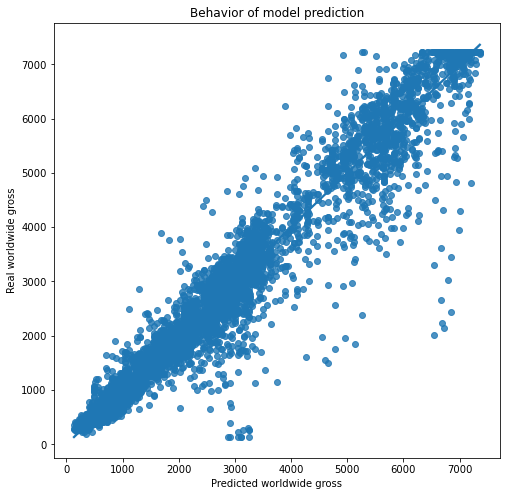

In [74]:
# Crear una pipeline que incluya el ColumnTransformer y el XGBRegressor
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', XGBRegressor(random_state=42))])

# Definir los parametros para el GridSearchCV
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.1, 0.05, 0.01]
}

# Realizar el GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X, y)

# realizar validacion cruzada
final_result = cross_validate(grid.best_estimator_, X_train, y_train, return_train_score=True, cv=5)
train_score = np.mean(final_result['train_score'])
test_score = np.mean(final_result['test_score'])
assert train_score > 0.7
assert test_score > 0.65

# Mostrar los resultados
print("Mejor puntaje: ", grid.best_score_)
print("Mejores parametros: ", grid.best_params_)

validation_score = grid.best_estimator_.score(X_test, y_test)

y_pred = grid.best_estimator_.predict(X_test)

# Cálculo de las métricas
rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

save_simple_metrics_report(train_score, test_score, validation_score, rmse, mae, mape, grid.best_estimator_)
get_model_performance_test_set(y_test, y_pred)
update_model(grid.best_estimator_)

In [76]:
y_test.mean()

3191.7912483424893

In [79]:
print(f'R2={validation_score}')
print(f'Mean Absolute Error={mae} - media de test = {y_test.mean()}')
print(f'Mean Squared Error / media test = {mae/y_test.mean()}')
print(f'Mean Absolute Percentage Error={mape}')
print(f'Mean Squared Error={rmse}')

R2=0.9391501390769222
Mean Absolute Error=322.8454072362976 - media de test = 3191.7912483424893
Mean Squared Error / media test =0.10114865983292379
Mean Squared Error=261629.28549990233
Mean Absolute Percentage Error=0.1723046436272906


Algunas de las métricas más comunes para evaluar un modelo de pronóstico son:

- Mean Absolute Error (MAE): Es la media del valor absoluto de los errores entre las predicciones y los valores reales. Un valor bajo de MAE indica un buen desempeño del modelo. Pero uno de los primeros problemas de este KPI es que no se escala a la demanda promedio por eso hay que contrastarlo con la media de y_test para saber el porcentaje, en este caso vemos buen resultado de este KPI, Donde tenemos al rededor de 10% de error.

- Root Mean Squared Error (RMSE): Es la raíz cuadrada de la MSE. Es una medida más interpretable que la MSE ya que tiene las mismas unidades que la variable pronosticada.

- Mean Absolute Percentage Error (MAPE): Es la media del error absoluto en términos porcentuales. Es una medida común en pronósticos de series de tiempo y permite comparar la precisión de diferentes modelos en una misma escala. Pero el  MAPE divide cada error individualmente por la demanda, para nosostros la cantida de autos, por lo que está sesgado: los errores altos durante los períodos de baja demanda afectarán significativamente a MAPE. Debido a esto, la optimización de MAPE dará como resultado un pronóstico extraño que probablemente superará la demanda de autos. deberiamos de evitarlo.

- Coefficient of Determination (R2): Es una medida de bondad de ajuste del modelo. Un valor cercano a 1 indica un buen ajuste del modelo a los datos.

Estas son solo algunas de las métricas comunes para evaluar un modelo de pronóstico. La elección de la métrica depende de las características específicas del problema y del objetivo de la predicción.

In [84]:
import datetime
import pandas as pd
start = datetime.datetime.strptime("01-12-2021", "%d-%m-%Y")
date_generated = pd.date_range(start, periods=31)
date_generated
# print(date_generated.strftime("%d-%m-%Y"))

DatetimeIndex(['2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15', '2021-12-16',
               '2021-12-17', '2021-12-18', '2021-12-19', '2021-12-20',
               '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
               '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', freq='D')

In [113]:
date = list(date_generated.strftime("%Y-%m-%d"))
dic = pd.DataFrame()
for row in date:
    hour = range(25)
    time = [row] * 24
    zipped = list(zip(hour, time))
    temp = pd.DataFrame(zipped, columns=['Hora', 'Fecha'])
    dic = dic.append(temp)

dic['Fecha'] = pd.to_datetime(dic['Fecha'])
dic['dia'] = dic['Fecha'].dt.weekday
dic['mes'] = dic['Fecha'].dt.month
dic['anio'] = dic['Fecha'].dt.year
dic['Fecha_Hora'] = pd.to_datetime(dic['Fecha']) + pd.to_timedelta(dic['Hora'], unit='h')
dic.set_index(dic['Fecha_Hora'],inplace=True)
dic.drop(columns=['Fecha_Hora', 'Fecha'], inplace=True)
dic['Auto_Nombre'] = 'AU 4  Lugones'
dic = dic[['Hora', 'Auto_Nombre', 'dia','mes','anio']]
dic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2021-12-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Hora         744 non-null    int64 
 1   Auto_Nombre  744 non-null    object
 2   dia          744 non-null    int64 
 3   mes          744 non-null    int64 
 4   anio         744 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 34.9+ KB


In [114]:
y_pred = grid.best_estimator_.predict(dic)
y_pred

array([1523.0709 ,  984.67737,  658.44434,  554.9732 ,  918.903  ,
       2289.9346 , 5127.08   , 7172.624  , 7344.1597 , 7333.9844 ,
       7197.663  , 7200.8857 , 7221.4194 , 7114.4224 , 6960.5093 ,
       6989.4033 , 7068.5776 , 7132.102  , 6969.0967 , 6341.399  ,
       5412.612  , 4058.614  , 2723.4238 , 2106.783  , 1570.898  ,
        996.5079 ,  663.39325,  550.0047 ,  909.34705, 2250.669  ,
       5085.1045 , 7130.6484 , 7302.184  , 7292.009  , 7155.6875 ,
       7158.91   , 7194.8384 , 7087.8413 , 6932.457  , 6961.351  ,
       7098.66   , 7162.1846 , 6999.18   , 6559.746  , 5654.385  ,
       4315.774  , 3007.6287 , 2454.689  , 2111.3857 , 1478.9783 ,
        898.8259 ,  732.45746, 1055.711  , 2299.5066 , 5125.436  ,
       7018.7266 , 7165.992  , 7179.638  , 7115.4385 , 7121.9985 ,
       7199.6997 , 7166.589  , 7055.761  , 7079.6504 , 7198.4614 ,
       7290.7812 , 7361.2266 , 7275.588  , 6548.8286 , 5313.174  ,
       3734.9578 , 3003.2373 , 2691.6804 , 2132.9128 , 1460.30